In [0]:
import numpy as np
import tensorflow as tf
import chess
import pandas as pd
import io

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input 
from tensorflow.keras.models import load_model

from keras import backend as K
from tensorflow import keras

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Helper Functions~~~

In [0]:
NUM_OUTPUTS = 5


def get_mat(board, piece, color):
  squareSet = board.pieces(piece, color)
  return get_bin_mat(squareSet);

def get_bin_mat(squareSet):
  mat = np.zeros((8,8))
  for x in range(0, 8):
    for y in range(0, 8):
        if(y*8 + x in squareSet):
          # The 7 - is used to flip the board representation
          mat[7 - y, x] = 1
            
  return mat


def get_dual_bin_mat(piece):
  whiteSquareSet = board.pieces(piece, chess.WHITE)
  blackSquareSet = board.pieces(piece, chess.BLACK)
  mat = np.zeros((8,8))
  for x in range(0, 8):
    for y in range(0, 8):
        if(y*8 + x in whiteSquareSet):
          # The 7 - is used to flip the board representation
          mat[7 - y, x] = 1
        elif(y*8 + x in blackSquareSet):
          mat[7 - y, x] = -1
            
  return mat


def interpret_pred(p):
  
  moves = []
  for out in p:
    # There's an extra list wrapping for some reason
    out = out[0]
    start = np.argmax(out[:64])
    end = np.argmax(out[64:])
       
    moves.append((chess.SQUARE_NAMES[start],
                  chess.SQUARE_NAMES[end]))
    
  return moves
  

def create_input(board):
  if(board.turn):
    turnMat = np.ones((8,8))
  else:
    turnMat = np.negative(np.ones((8,8)))
  mat = np.array(([get_mat(board, i, chess.WHITE) for i in range(1,7)] + [get_mat(board, i, chess.BLACK) for i in range(1,7)] + [turnMat]))
  y = mat.reshape((-1, 13, 8, 8))
  return y

def create_output(moves):
  output = []
  for i in range(0, NUM_OUTPUTS):
    startPos = moves[i][0]
    endPos = moves[i][1]
    
    mat = np.zeros(128)
    
    mat[startPos] = 1
    mat[64 + endPos] = 1
        
    output.append(mat)
  
  return output

def create_training_set(df):
  inputs = []
  outputs = []

  for i in range(len(df)):
    pos = df.iloc[i].Position
    moves = eval(df.iloc[i].Moves)

    board.set_fen(pos)
    if i > 0:
      inputs = np.append(inputs, create_input(board), axis=0)
    else:
      inputs = create_input(board)
    #outputs.append(create_output(moves))
    
  for j in range(0, NUM_OUTPUTS):
    output = []
    for k in range(len(df)):
      moves = eval(df.iloc[k].Moves)

      startPos = moves[j][0]
      endPos = moves[j][1]
    
      mat = np.zeros(128)

      mat[startPos] = 1
      mat[64 + endPos] = 1
        
      output.append(mat)
    
    outputs.append(output)

  return (inputs, outputs)

In [0]:
np.zeros(128).shape

(128,)

Input data:

  (6 pieces) * 2 players + 1 for turn
  
  8 rows
  
  8 columns
  
 => 8 * 8 * 13 = 832
 
 
 Output data:
 
 - Assume predicting five moves
 - initial location, and new location
 
 
Array of objects/tuples
[{initial location, new location},...]
 
 
 => 5 * 2 * 64 = 640
  

In [0]:
inp = Input((13,8,8))


x = Conv2D(250, kernel_size=3, activation='relu', input_shape=(13,8,8))(inp)

x = Conv2D(250, kernel_size=3, activation='relu', input_shape=(13,8,8))(x)

x = Conv2D(250, kernel_size=3, activation='relu', input_shape=(13,8,8))(x)


x = Flatten()(x)


outputs = []

for n in range(NUM_OUTPUTS):
  outputs.append(Dense(128, activation='softmax')(x))

model = Model(inp, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

model.summary()

W0831 20:32:10.724762 140405445924736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13, 8, 8)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 11, 6, 250)   18250       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 4, 250)    562750      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 2, 250)    562750      conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
board = chess.Board()

y = create_input(board)

p = model.predict(y)

interpret_pred(p)

[('f7', 'h2'), ('c7', 'c5'), ('g2', 'd3'), ('a3', 'a3'), ('b8', 'c4')]

In [0]:
df=pd.read_csv('drive/My Drive/Chess/train2.csv')

df.head()

,Position,Moves
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,"[(4, 28), (4, 28), (4, 28), (4, 28), (4, 28)]"
1,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,"[(4, 28), (4, 28), (4, 28), (4, 28), (4, 28)]"
2,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,"[(4, 28), (4, 28), (4, 28), (4, 28), (4, 28)]"
3,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,"[(4, 28), (4, 28), (4, 28), (4, 28), (4, 28)]"
4,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,"[(4, 28), (4, 28), (4, 28), (4, 28), (4, 28)]"


In [0]:
df = df[:1000] # Set an initial limit

SPLIT_SIZE = 1000
NUM_CHUNKS = len(df)/SPLIT_SIZE

i = 1
for chunk in np.array_split(df, NUM_CHUNKS):
  inputs, outputs = create_training_set(chunk)
  model.fit(inputs, outputs, epochs=5)
  print('Model fit for ' + str(i * SPLIT_SIZE) + 'training samples.')
  i = i + 1

Epoch 1/5
1000/1000 [==============================] - 1s 1ms/sample - loss: 133.0555 - dense_loss: 50.6969 - dense_1_loss: 20.3720 - dense_2_loss: 28.6638 - dense_3_loss: 24.5365 - dense_4_loss: 24.3783 - dense_acc: 0.3200 - dense_1_acc: 0.4160 - dense_2_acc: 0.5520 - dense_3_acc: 0.3520 - dense_4_acc: 0.6160
Epoch 2/5
1000/1000 [==============================] - 1s 619us/sample - loss: 6385.9594 - dense_loss: 2320.3086 - dense_1_loss: 804.1963 - dense_2_loss: 1418.4358 - dense_3_loss: 794.6599 - dense_4_loss: 1343.2797 - dense_acc: 0.5120 - dense_1_acc: 0.4880 - dense_2_acc: 0.5120 - dense_3_acc: 0.5120 - dense_4_acc: 0.5200
Epoch 3/5
1000/1000 [==============================] - 1s 604us/sample - loss: 63325.0720 - dense_loss: 22393.1094 - dense_1_loss: 7636.9727 - dense_2_loss: 13569.5664 - dense_3_loss: 7650.1016 - dense_4_loss: 14236.3984 - dense_acc: 0.5120 - dense_1_acc: 0.4880 - dense_2_acc: 0.4800 - dense_3_acc: 0.5120 - dense_4_acc: 0.4800
Epoch 4/5
1000/1000 [===============

In [0]:
board = chess.Board()

y = create_input(board)

p = model.predict(y)

interpret_pred(p)

[('a1', 'e4'), ('e1', 'a1'), ('a1', 'e4'), ('a1', 'e4'), ('a1', 'e4')]

array([[[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
       

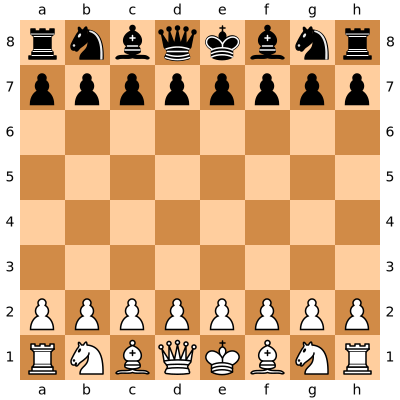

In [0]:
board

In [0]:
## Save Model
# model.save('./drive/My Drive/Chess/simple_cnn.h5')

## Load Model
# model = load_model('./drive/My Drive/Chess/simple_cnn.h5')

In [0]:
# p2 = odel.predict(y)
# interpret_pred(p2)